In [147]:
import json
import numpy as np
import networkx as nx
import tqdm
import os
import yaml
import pickle

#path_to_workload = "/home/lenovo/Downloads/trace_0_FLOW_THROUGHPUT-1250000__SIMULATION_TIME-100000000__PAIRS_PER_SRC-1-0__MSG_SIZE-10000__PACKET_SIZE-1400__BANDWIDTH-1250000__PRIO_LEVELS-3"
path_to_workload = "/home/lenovo/Downloads/final_workload"
path_to_topology = "/home/lenovo/Documents/GitHub/experiment-utils/src/data/reindexed.json"
subgraph_number = 0


# read topo data
with open(path_to_topology,'r') as f:
    data = json.load(f)

# get nodes and egdes
nodes, edges = data['nodeList'], data['edgeList']
NUM_NODES, NUM_EDGES = len(nodes), len(edges)

# creating some usefull maps to get information regarding the nodes
try:
    new_to_old = {}
    for node in nodes:
        new_to_old[node['id']] = node['old_id']
except KeyError:
    print("OLD_ID in topology... ingoring new_to_old structure")

id_to_node = {}
for node in nodes:
    id_to_node[node['id']] = node

port_map = {}
for node in nodes:
    port_map[node['id']] = {}
    for port in node['portList']:
        port_map[node['id']][port['id']] = port


In [148]:
g = nx.DiGraph()

connection_info = {node['id']: {} for node in nodes}

for edge in edges:
    src, src_port, dest, dest_port = edge['srcNode'], edge['srcPort'], edge['destNode'], edge['destPort']
    src_bw, dest_bw = port_map[src][src_port]['bw'], port_map[dest][dest_port]['bw']
    
    connection_info[src][dest] = port_map[src][src_port]

    g.add_edge(src, dest)

print(g)

DiGraph with 8979 nodes and 21082 edges


In [149]:
# get the nodes of the subgraphs in the topology
subgraphs = list(nx.strongly_connected_components(g))

# get the topology of selected subgraph
g = g.subgraph(subgraphs[subgraph_number])

print(g)

DiGraph with 5237 nodes and 12149 edges


In [150]:
flows = {}
with open(path_to_workload, 'r') as f:
    for line in f:
        src, dest = int(line.split(' ')[1]), int(line.split(" ")[2])

        if src in flows.keys():
            flows[src].add(dest)
        else:
            flows[src] = set([dest])

In [151]:
def generate_partitions(num_partitions):
    partitions = {}

    for node in nodes:
        partitions[node['id']] = node['id'] % num_partitions
    
    return partitions


In [152]:
def analyse_flow(route, partitions):
    partitions_span = set()
    
    for node_id in route:
        partitions_span.add(partitions[node_id])
    
    return len(partitions_span)


In [153]:
def analyse_partion(partitions):
    results = []
    for src, flow_set in flows.items():
        flow_list = list(flow_set)

        for dst in flow_list:
            path = nx.shortest_path(g, src, dst)
            span = analyse_flow(path, partitions)
            
            results.append({
                "src": src,
                "dest": dst,
                "span": span
            })
    
    return results

In [183]:
prcnt = lambda val, total : round((val/total) * 100, 2)

def process_results(results):
    spans = [x['span'] for x in results]

    count_spans = {}
    for span in spans:
        count_spans[span] = count_spans.get(span, 0) + 1

    total_flows = sum([x for x in count_spans.values()])

    count_spans = [(key, value) for key, value in count_spans.items()]
    count_spans = sorted(count_spans, key=lambda x:x[0])
    count_spans_sorted = {x[0]:x[1] for x in count_spans}
    count_spans_prcnt = {x[0]:prcnt(x[1],total_flows) for x in count_spans}

    return count_spans_sorted, count_spans_prcnt, spans


In [195]:
num_partitions = 64
partitions = generate_partitions(num_partitions)
results = analyse_partion(partitions)
normal, prc, spans = process_results(results)
print(prc)

{1: 0.04, 2: 0.02, 3: 0.14, 4: 0.21, 5: 0.89, 6: 2.21, 7: 4.16, 8: 6.02, 9: 9.07, 10: 10.47, 11: 11.44, 12: 11.32, 13: 10.58, 14: 9.05, 15: 7.3, 16: 6.04, 17: 3.81, 18: 2.78, 19: 1.67, 20: 1.38, 21: 0.76, 22: 0.33, 23: 0.19, 24: 0.06, 25: 0.04, 26: 0.02}


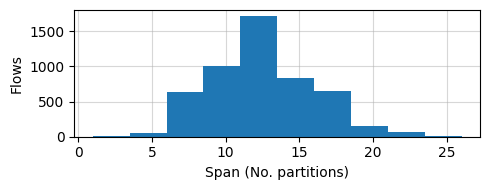

In [196]:
import matplotlib.pyplot as plt

# Sample data in dictionary format (bins and frequencies)
data_dict = prc

# Extract bins and frequencies from the dictionary
bins = list(data_dict.keys())
frequencies = list(data_dict.values())

# Create figure and axes objects
fig, ax = plt.subplots()
fig.set_figwidth(5)
fig.set_figheight(2)

# Plot the histogram
#ax.bar(bins, frequencies, zorder=2)
ax.hist(spans, zorder=2)
# Customize labels and title
ax.set_xlabel('Span (No. partitions)')
ax.set_ylabel('Flows')
#ax.set_xticks(ticks=range(0,num_partitions))
# Show the plot
plt.grid(alpha=.5)
plt.tight_layout()
plt.show()